In [1]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
import ternary
import random
import plotly.figure_factory as ff

In [2]:
def creating_samples(samples_number, element):
    gen=0
    uniform_number = len(element)
    uniform_samples = (-qe.simplex_grid(len(element), 1)+1)/(len(element)-1)
    if samples_number > uniform_number:
        random_samples = np.random.rand((samples_number-uniform_number), len(element))
        for i in range(samples_number-uniform_number):
            random_samples[i] = np.around(random_samples[i]/sum(random_samples[i]), decimals = 3)
        sample = np.vstack((uniform_samples, random_samples))
    else:
        sample = uniform_samples[:samples_number]
    samples = []
    for i in range(samples_number):
        samples.append(list(sample[i]))
    samples = np.array(samples)
    generation = []
    for i in range (samples_number):
            generation.append(gen)

    ID = np.arange(1, (samples_number+1))

    data = {'ID' : ID, 'Elements': [element], 'Generation': generation}
    df = pd.DataFrame(data=data, index = np.arange(samples_number))
    df = pd.concat([df, pd.DataFrame(([[i] for i in samples]), columns = ['Position'])], axis = 1)
    df.to_csv("Result/Initial Population.txt", sep='\t', index=False, mode='w')
    return df

In [3]:
#Loading data and fitting
df_old = pd.read_csv('Data/AuIrOsPdPtReRhRu_0.60_compositions_and_targets.csv')
X_columns_old = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
x_old = df_old[X_columns_old].to_numpy()
y_old = df_old['current_over_capacitance'].to_numpy()

#Rndom Forest Regression
reg = RandomForestRegressor(n_estimators = 1024,
                           bootstrap = True,
                           max_depth = None,
                           max_features = 'auto',
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           oob_score = True)
reg = reg.fit(x_old, y_old)

In [4]:
#Determine the best position
grid = qe.simplex_grid(3, 1000)/1000
zeros = np.zeros(len(grid)).reshape(-1,1)

grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = pd.DataFrame(grid,columns=[X_columns_old])
grid['Activity'] = reg.predict(grid.to_numpy())
best_grid = grid.iloc[np.argmin(grid['Activity'])][0:3].to_numpy()

In [62]:
len(grid)

501501

In [5]:
print(best_grid, grid.iloc[np.argmin(grid['Activity'])]['Activity'])

[0.455 0.294 0.251] -1.0392912597656243


In [49]:
#Making Class
class pso:
    def __init__ (self, data, size=0.20, target = np.array([0.333, 0.333, 0.333])):
        self.datalog = data
        #Reading "Elements" columns from string to list
        self.datalog['Elements'] = self.datalog["Elements"].apply(lambda x: literal_eval(x))
        
        #Select latest generation
        self.generation = self.datalog['Generation'].max()
        
        #Creating np.array of "Position" column and dropping the string type "Position" column
        self.position = []
        for i in range(self.datalog['ID'].max()):
            self.position.append(list(np.fromstring(self.datalog['Position'][i][1:-1], dtype=float, sep=' ')))
        self.position = np.array(self.position)
        self.datalog = self.datalog.drop(columns=['Position'])
        self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.position]), columns = ['Position'])], axis = 1)
        
        #Creating "Velocity" column for the "0" generation
        if self.generation == 0:
            self.velocity = np.around((-(self.position - target)), decimals = 3)
            self.velocity = np.around((self.unit_vector_velocity()*size), decimals = 3)
            self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.velocity]), columns = ['Velocity'])], axis = 1)

        
        #Creating blank "Activity" column
        self.datalog = pd.concat([self.datalog, pd.DataFrame(columns = ['Activity'], index = np.arange(self.datalog['ID'].max()))], axis = 1)      

        #Filling the "Activity" column with RFR
        self.f_activity(self.datalog)
            
        #Creating dataframe of the latest generation
        self.working_generation = self.datalog.loc[self.datalog['Generation']==self.generation]
    
    
            
    def move(self, factor_1, factor_2, factor_3, mutation_rate, mutation_prob, limit_velocity):
        #Performing move function  
        self.generation += 1
        self.working_generation['Generation'] += 1
        
        #Creating new velocity
        for i in range(len(self.working_generation)):
            new_velocity = -(factor_1 * self.working_generation.at[i, 'Velocity'] + 
                        factor_2 * self.delta_gen_best((i+1), 'Activity') * self.delta_gen_best((i+1), 'Position') + 
                        factor_3 * self.delta_individual_best((i+1), 'Activity') * self.delta_individual_best((i+1), 'Position'))       
            

            #Setting limit velocity
            new_velocity[new_velocity > limit_velocity] = limit_velocity
            new_velocity[new_velocity < -limit_velocity] = -limit_velocity
            
            #Mutation process
            self.working_generation.at[i,'Velocity'] = self.mutate(new_velocity, mutation_rate, mutation_prob, limit_velocity)
            

            
        #Normalization
        self.normalize_velocity()
            
        #Changing position
        for i in range(len(self.working_generation)):    
            new_position = self.working_generation['Position'][i] + self.working_generation['Velocity'][i]
            if new_position.max() > 1 or new_position.min() < 0:
                new_position = self.working_generation['Position'][i] - self.working_generation['Velocity'][i]*2
            self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)
                
        
        #Filling the "Activity" column with RFR
        self.f_activity(self.working_generation)
        
        #Concating the tables
        self.datalog = pd.concat([self.datalog, self.working_generation])
        self.datalog = self.datalog.reset_index(drop=True)
        self.store_datalog()
        return
    
    def f_activity(self, dataframe):
        global reg
        a = [0, 0, 0, 0, 0]
        for i in range(len(dataframe)):
            dataframe.at[i, 'Activity'] = float(reg.predict(np.reshape((np.hstack((dataframe.at[i, 'Position'], a))), (1, -1))))
        return 

 
    def unit_vector_velocity(self):
        self.unit_vector_velocity = []
        for i in range(self.datalog['ID'].max()):
            self.unit_vector_velocity.append(list(self.velocity[i]/np.sqrt(sum(self.velocity[i]**2))))
        self.unit_vector_velocity = np.around(np.array(self.unit_vector_velocity), decimals = 3)
        return self.unit_vector_velocity
    
    def normalize_velocity(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] - (sum(self.working_generation.at[i, 'Velocity'])/len(self.working_generation['Elements'][0]))
            self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return

    def mutate(self, new_velocity, mutation_rate, mutation_prob, limit_velocity):
        mutated_velocity = []
        for i in range(len(new_velocity)):
            mutation = np.random.rand()
            step_size_i = 0
            if mutation < mutation_prob:
                step_size_i = np.random.uniform((0-mutation_rate), (0+mutation_rate))
            mutated_velocity.append(new_velocity[i] + limit_velocity * step_size_i)
        mutated_velocity = np.array(mutated_velocity)
        return mutated_velocity
    
    """def normalize_position(self):
        for i in range(len(self.working_generation)):
            if self.working_generation.at[i, 'Position'].min() < 0:
                self.working_generation.at[i, 'Position'] = self.working_generation.at[i, 'Position'] - self.working_generation.at[i, 'Position'].min()
            self.working_generation.at[i, 'Position'] = self.working_generation.at[i, 'Position']/(sum(self.working_generation.at[i, 'Position']))
            self.working_generation.at[i, 'Position'] = np.around(self.working_generation.at[i, 'Position'], decimals= 3)
        return"""
           
    
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def gen_best(self):
        return self.working_generation.loc[np.argmin(self.working_generation['Activity'])]
           
    def individual_best(self, ID):
        self.i_data = self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
        return self.i_data.loc[np.argmin(self.i_data['Activity'])]
    
    def delta_gen_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.gen_best()[parameter]
    
    def delta_individual_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.individual_best(ID)[parameter]      
    
    
    def individual_log(self, ID):
        return self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
    
    def store_datalog(self):
        self.datalog.to_csv("Result/Initial Population_gen "+str(self.generation)+".txt", sep='\t', index=False, mode='w')
        return
    
    def plot(self):
        points = []
        IDs = []
        color = ['black', 'magenta', 'red', 'blue', 'green', 'gray', 'yellow']
        colors = [] 
        for i in range(len(self.working_generation)):
            IDs.append('ID = '+str(i+1))
            colors.append(color[i]) 
            for x in range(self.generation+1):
                points.append(tuple(self.individual_log(i+1)['Position'][x]))

        #Parameter for plotting
        scale = 1
        figure, tax = ternary.figure(scale=scale)
        figure.set_size_inches(10, 10)

        #Plotting the starting points
        for i in range(len(self.working_generation)):
            tax.scatter([points[(self.generation+1)*i]], marker='*', color=color[i], label=IDs[i])
            #Plotting the movement
            for x in range(self.generation):
                tax.scatter([points[(self.generation+1)*i+(x+1)]], marker='*', color=color[i])
        tax.legend()

        tax.set_title("Particle Swarm Scatter Plot", fontsize=20)
        tax.boundary(linewidth=1.0)
        tax.gridlines(multiple=0.1, color="blue")
        tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
        tax.clear_matplotlib_ticks()
        tax.get_axes().axis('off')
        tax.show() 
        return 

In [23]:
samples_number = 6
element = ['Pt', 'Pd', 'Au']
creating_samples(samples_number, element)

,ID,Elements,Generation,Position
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]"
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]"
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]"
3,4,"[Pt, Pd, Au]",0,"[0.618, 0.236, 0.147]"
4,5,"[Pt, Pd, Au]",0,"[0.544, 0.331, 0.124]"
5,6,"[Pt, Pd, Au]",0,"[0.486, 0.305, 0.209]"


In [24]:
size = 0.05
target = np.array([0.333, 0.333, 0.333])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), size, target)

In [25]:
population.datalog

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]","[-0.02, -0.02, 0.041]",-0.950659
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]","[-0.02, 0.041, -0.02]",-0.924154
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]","[0.041, -0.02, -0.02]",-0.279065
3,4,"[Pt, Pd, Au]",0,"[0.618, 0.236, 0.147]","[-0.04, 0.014, 0.026]",-0.962207
4,5,"[Pt, Pd, Au]",0,"[0.544, 0.331, 0.124]","[-0.036, 0.0, 0.035]",-0.961658
5,6,"[Pt, Pd, Au]",0,"[0.486, 0.305, 0.209]","[-0.038, 0.007, 0.031]",-0.985234


In [26]:
factor_1 = 0.98
factor_2 = 0.6
factor_3 = 0.7
mutation_prob = 0.7
mutation_rate = 0.3
limit_velocity = 0.1

for i in range(20):
    population.move(factor_1, factor_2, factor_3, mutation_prob, mutation_rate, limit_velocity)
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",1,"[0.442, 0.506, 0.052]","[0.029, -0.003, -0.026]",-0.953335
1,2,"[Pt, Pd, Au]",1,"[0.506, 0.102, 0.392]","[-0.003, -0.051, 0.054]",-0.940363
2,3,"[Pt, Pd, Au]",1,"[0.111, 0.448, 0.442]","[0.111, -0.052, -0.058]",-0.761201
3,4,"[Pt, Pd, Au]",1,"[0.638, 0.264, 0.098]","[0.02, 0.028, -0.049]",-0.962883
4,5,"[Pt, Pd, Au]",1,"[0.578, 0.33, 0.091]","[0.034, -0.001, -0.033]",-0.964209
5,6,"[Pt, Pd, Au]",1,"[0.523, 0.298, 0.179]","[0.037, -0.007, -0.03]",-0.973512


[0.486 0.305 0.209] -0.9852341699218746
0.05334791467339656


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",2,"[0.415, 0.506, 0.079]","[-0.027, 0.0, 0.027]",-0.954238
1,2,"[Pt, Pd, Au]",2,"[0.508, 0.157, 0.335]","[0.002, 0.055, -0.057]",-0.994467
2,3,"[Pt, Pd, Au]",2,"[0.055, 0.48, 0.466]","[-0.056, 0.032, 0.024]",-0.305885
3,4,"[Pt, Pd, Au]",2,"[0.617, 0.236, 0.146]","[-0.021, -0.028, 0.048]",-0.962207
4,5,"[Pt, Pd, Au]",2,"[0.523, 0.365, 0.111]","[-0.055, 0.035, 0.02]",-0.958651
5,6,"[Pt, Pd, Au]",2,"[0.486, 0.305, 0.209]","[-0.037, 0.007, 0.03]",-0.985234


[0.508 0.157 0.335] -0.994466923828125
0.1692158385021922


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",3,"[0.422, 0.541, 0.037]","[0.007, 0.035, -0.042]",-0.952123
1,2,"[Pt, Pd, Au]",3,"[0.484, 0.081, 0.435]","[-0.024, -0.076, 0.1]",-0.929439
2,3,"[Pt, Pd, Au]",3,"[0.178, 0.456, 0.368]","[0.123, -0.024, -0.098]",-0.964427
3,4,"[Pt, Pd, Au]",3,"[0.635, 0.262, 0.102]","[0.018, 0.026, -0.044]",-0.961115
4,5,"[Pt, Pd, Au]",3,"[0.534, 0.333, 0.132]","[0.011, -0.032, 0.021]",-0.959455
5,6,"[Pt, Pd, Au]",3,"[0.517, 0.285, 0.197]","[0.031, -0.02, -0.012]",-0.976639


[0.508 0.157 0.335] -0.994466923828125
0.1692158385021922


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",4,"[0.435, 0.466, 0.099]","[0.013, -0.075, 0.062]",-0.956475
1,2,"[Pt, Pd, Au]",4,"[0.492, 0.147, 0.361]","[0.008, 0.066, -0.074]",-0.986806
2,3,"[Pt, Pd, Au]",4,"[0.072, 0.473, 0.457]","[-0.106, 0.017, 0.089]",-0.437312
3,4,"[Pt, Pd, Au]",4,"[0.622, 0.267, 0.11]","[-0.013, 0.005, 0.008]",-0.96183
4,5,"[Pt, Pd, Au]",4,"[0.523, 0.364, 0.112]","[-0.011, 0.031, -0.02]",-0.959289
5,6,"[Pt, Pd, Au]",4,"[0.494, 0.288, 0.217]","[-0.023, 0.003, 0.02]",-1.006355


[0.494 0.288 0.217] -1.0063549414062498
0.05208646657242166


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",5,"[0.424, 0.534, 0.042]","[-0.011, 0.068, -0.057]",-0.951808
1,2,"[Pt, Pd, Au]",5,"[0.484, 0.084, 0.432]","[-0.008, -0.063, 0.071]",-0.930484
2,3,"[Pt, Pd, Au]",5,"[0.201, 0.416, 0.386]","[0.129, -0.057, -0.071]",-0.963788
3,4,"[Pt, Pd, Au]",5,"[0.626, 0.273, 0.1]","[0.004, 0.006, -0.01]",-0.962867
4,5,"[Pt, Pd, Au]",5,"[0.533, 0.331, 0.134]","[0.01, -0.033, 0.022]",-0.959524
5,6,"[Pt, Pd, Au]",5,"[0.509, 0.318, 0.172]","[0.015, 0.03, -0.045]",-0.973127


[0.494 0.288 0.217] -1.0063549414062498
0.05208646657242166


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",6,"[0.45, 0.457, 0.093]","[0.026, -0.077, 0.051]",-0.959886
1,2,"[Pt, Pd, Au]",6,"[0.507, 0.148, 0.345]","[0.023, 0.064, -0.087]",-0.98713
2,3,"[Pt, Pd, Au]",6,"[0.093, 0.463, 0.446]","[-0.108, 0.047, 0.06]",-0.729499
3,4,"[Pt, Pd, Au]",6,"[0.621, 0.267, 0.11]","[-0.005, -0.006, 0.01]",-0.96183
4,5,"[Pt, Pd, Au]",6,"[0.508, 0.398, 0.092]","[-0.025, 0.067, -0.042]",-0.960528
5,6,"[Pt, Pd, Au]",6,"[0.489, 0.291, 0.22]","[-0.02, -0.027, 0.048]",-1.012316


[0.489 0.291 0.22 ] -1.0123161621093746
0.04610856753359399


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",7,"[0.393, 0.532, 0.075]","[-0.057, 0.075, -0.018]",-0.954238
1,2,"[Pt, Pd, Au]",7,"[0.484, 0.087, 0.428]","[-0.023, -0.061, 0.083]",-0.930902
2,3,"[Pt, Pd, Au]",7,"[0.194, 0.424, 0.383]","[0.101, -0.039, -0.063]",-0.969784
3,4,"[Pt, Pd, Au]",7,"[0.599, 0.25, 0.149]","[-0.022, -0.017, 0.039]",-0.961296
4,5,"[Pt, Pd, Au]",7,"[0.527, 0.339, 0.132]","[0.019, -0.059, 0.04]",-0.959381
5,6,"[Pt, Pd, Au]",7,"[0.489, 0.298, 0.213]","[0.0, 0.007, -0.007]",-0.983611


[0.489 0.291 0.22 ] -1.0123161621093746
0.04610856753359399


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",8,"[0.45, 0.456, 0.094]","[0.057, -0.076, 0.019]",-0.959886
1,2,"[Pt, Pd, Au]",8,"[0.515, 0.164, 0.32]","[0.031, 0.077, -0.108]",-1.005701
2,3,"[Pt, Pd, Au]",8,"[0.143, 0.438, 0.42]","[-0.051, 0.014, 0.037]",-0.899689
3,4,"[Pt, Pd, Au]",8,"[0.619, 0.267, 0.112]","[0.02, 0.017, -0.037]",-0.96351
4,5,"[Pt, Pd, Au]",8,"[0.526, 0.414, 0.058]","[-0.001, 0.075, -0.074]",-0.954343
5,6,"[Pt, Pd, Au]",8,"[0.485, 0.298, 0.216]","[-0.004, 0.0, 0.003]",-1.004883


[0.489 0.291 0.22 ] -1.0123161621093746
0.04610856753359399


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",9,"[0.373, 0.534, 0.093]","[-0.077, 0.078, -0.001]",-0.959886
1,2,"[Pt, Pd, Au]",9,"[0.487, 0.09, 0.422]","[-0.028, -0.074, 0.102]",-0.937228
2,3,"[Pt, Pd, Au]",9,"[0.195, 0.418, 0.388]","[0.052, -0.02, -0.032]",-0.968442
3,4,"[Pt, Pd, Au]",9,"[0.597, 0.248, 0.154]","[-0.022, -0.019, 0.042]",-0.962937
4,5,"[Pt, Pd, Au]",9,"[0.515, 0.32, 0.163]","[-0.011, -0.094, 0.105]",-0.972087
5,6,"[Pt, Pd, Au]",9,"[0.452, 0.309, 0.238]","[-0.033, 0.011, 0.022]",-1.033893


[0.452 0.309 0.238] -1.033893115234374
0.02007485989988475


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",10,"[0.453, 0.459, 0.089]","[0.08, -0.075, -0.004]",-0.959182
1,2,"[Pt, Pd, Au]",10,"[0.509, 0.174, 0.317]","[0.022, 0.084, -0.105]",-1.00697
2,3,"[Pt, Pd, Au]",10,"[0.16, 0.439, 0.402]","[-0.035, 0.021, 0.014]",-0.906946
3,4,"[Pt, Pd, Au]",10,"[0.613, 0.27, 0.117]","[0.016, 0.022, -0.037]",-0.963424
4,5,"[Pt, Pd, Au]",10,"[0.506, 0.446, 0.046]","[-0.009, 0.126, -0.117]",-0.951808
5,6,"[Pt, Pd, Au]",10,"[0.463, 0.277, 0.258]","[0.011, -0.032, 0.02]",-1.026464


[0.452 0.309 0.238] -1.033893115234374
0.02007485989988475


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",11,"[0.375, 0.526, 0.1]","[-0.078, 0.067, 0.011]",-0.95667
1,2,"[Pt, Pd, Au]",11,"[0.488, 0.094, 0.418]","[-0.021, -0.08, 0.101]",-0.939065
2,3,"[Pt, Pd, Au]",11,"[0.201, 0.44, 0.36]","[0.041, 0.001, -0.042]",-0.962868
3,4,"[Pt, Pd, Au]",11,"[0.611, 0.268, 0.12]","[-0.002, -0.002, 0.003]",-0.962844
4,5,"[Pt, Pd, Au]",11,"[0.511, 0.344, 0.144]","[0.005, -0.102, 0.098]",-0.958527
5,6,"[Pt, Pd, Au]",11,"[0.452, 0.308, 0.238]","[-0.011, 0.031, -0.02]",-1.033893


[0.452 0.309 0.238] -1.033893115234374
0.02007485989988475


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",12,"[0.471, 0.418, 0.112]","[0.096, -0.108, 0.012]",-0.958554
1,2,"[Pt, Pd, Au]",12,"[0.503, 0.184, 0.313]","[0.015, 0.09, -0.105]",-1.006687
2,3,"[Pt, Pd, Au]",12,"[0.206, 0.416, 0.379]","[0.005, -0.024, 0.019]",-0.962658
3,4,"[Pt, Pd, Au]",12,"[0.608, 0.267, 0.124]","[-0.003, -0.001, 0.004]",-0.962356
4,5,"[Pt, Pd, Au]",12,"[0.53, 0.416, 0.053]","[0.019, 0.072, -0.091]",-0.953829
5,6,"[Pt, Pd, Au]",12,"[0.485, 0.266, 0.246]","[0.033, -0.042, 0.008]",-1.02428


[0.452 0.309 0.238] -1.033893115234374
0.02007485989988475


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",13,"[0.366, 0.541, 0.094]","[-0.105, 0.123, -0.018]",-0.959886
1,2,"[Pt, Pd, Au]",13,"[0.478, 0.065, 0.456]","[-0.025, -0.119, 0.143]",-0.92856
2,3,"[Pt, Pd, Au]",13,"[0.211, 0.434, 0.356]","[0.005, 0.018, -0.023]",-0.961778
3,4,"[Pt, Pd, Au]",13,"[0.606, 0.268, 0.125]","[-0.002, 0.001, 0.001]",-0.962548
4,5,"[Pt, Pd, Au]",13,"[0.51, 0.338, 0.151]","[-0.02, -0.078, 0.098]",-0.959841
5,6,"[Pt, Pd, Au]",13,"[0.44, 0.297, 0.26]","[-0.045, 0.031, 0.014]",-1.037705


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",14,"[0.457, 0.432, 0.112]","[0.091, -0.109, 0.018]",-0.958554
1,2,"[Pt, Pd, Au]",14,"[0.494, 0.157, 0.348]","[0.016, 0.092, -0.108]",-0.986888
2,3,"[Pt, Pd, Au]",14,"[0.216, 0.41, 0.374]","[0.005, -0.024, 0.018]",-0.962324
3,4,"[Pt, Pd, Au]",14,"[0.584, 0.277, 0.138]","[-0.022, 0.009, 0.013]",-0.963058
4,5,"[Pt, Pd, Au]",14,"[0.526, 0.412, 0.06]","[0.016, 0.074, -0.091]",-0.954814
5,6,"[Pt, Pd, Au]",14,"[0.433, 0.269, 0.295]","[-0.007, -0.028, 0.035]",-1.023419


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",15,"[0.321, 0.555, 0.125]","[-0.136, 0.123, 0.013]",-0.92117
1,2,"[Pt, Pd, Au]",15,"[0.479, 0.071, 0.449]","[-0.015, -0.086, 0.101]",-0.928632
2,3,"[Pt, Pd, Au]",15,"[0.206, 0.454, 0.34]","[-0.01, 0.044, -0.034]",-0.965097
3,4,"[Pt, Pd, Au]",15,"[0.592, 0.284, 0.123]","[0.008, 0.007, -0.015]",-0.965788
4,5,"[Pt, Pd, Au]",15,"[0.507, 0.333, 0.157]","[-0.019, -0.079, 0.097]",-0.962475
5,6,"[Pt, Pd, Au]",15,"[0.485, 0.274, 0.238]","[0.052, 0.005, -0.057]",-1.020636


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",16,"[0.417, 0.481, 0.103]","[0.096, -0.074, -0.022]",-0.956575
1,2,"[Pt, Pd, Au]",16,"[0.49, 0.165, 0.343]","[0.011, 0.094, -0.106]",-0.992239
2,3,"[Pt, Pd, Au]",16,"[0.197, 0.447, 0.356]","[-0.009, -0.007, 0.016]",-0.968022
3,4,"[Pt, Pd, Au]",16,"[0.552, 0.317, 0.13]","[-0.04, 0.033, 0.007]",-0.968117
4,5,"[Pt, Pd, Au]",16,"[0.525, 0.408, 0.064]","[0.018, 0.075, -0.093]",-0.954949
5,6,"[Pt, Pd, Au]",16,"[0.434, 0.269, 0.294]","[-0.051, -0.005, 0.056]",-1.023419


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",17,"[0.324, 0.545, 0.132]","[-0.093, 0.064, 0.029]",-0.91852
1,2,"[Pt, Pd, Au]",17,"[0.501, 0.031, 0.466]","[0.011, -0.134, 0.123]",-0.924508
2,3,"[Pt, Pd, Au]",17,"[0.235, 0.469, 0.296]","[0.038, 0.022, -0.06]",-0.972543
3,4,"[Pt, Pd, Au]",17,"[0.599, 0.279, 0.121]","[0.047, -0.038, -0.009]",-0.966168
4,5,"[Pt, Pd, Au]",17,"[0.518, 0.301, 0.178]","[-0.007, -0.107, 0.114]",-0.973365
5,6,"[Pt, Pd, Au]",17,"[0.481, 0.28, 0.236]","[0.047, 0.011, -0.058]",-1.020405


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",18,"[0.426, 0.465, 0.11]","[0.102, -0.08, -0.022]",-0.956575
1,2,"[Pt, Pd, Au]",18,"[0.486, 0.086, 0.426]","[-0.015, 0.055, -0.04]",-0.930902
2,3,"[Pt, Pd, Au]",18,"[0.236, 0.426, 0.337]","[0.001, -0.043, 0.041]",-0.964551
3,4,"[Pt, Pd, Au]",18,"[0.539, 0.336, 0.124]","[-0.06, 0.057, 0.003]",-0.961589
4,5,"[Pt, Pd, Au]",18,"[0.554, 0.38, 0.063]","[0.036, 0.079, -0.115]",-0.954949
5,6,"[Pt, Pd, Au]",18,"[0.448, 0.283, 0.265]","[-0.033, 0.003, 0.029]",-1.028476


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",19,"[0.327, 0.536, 0.138]","[-0.099, 0.071, 0.028]",-0.919766
1,2,"[Pt, Pd, Au]",19,"[0.488, 0.037, 0.473]","[0.002, -0.049, 0.047]",-0.924507
2,3,"[Pt, Pd, Au]",19,"[0.253, 0.442, 0.304]","[0.017, 0.016, -0.033]",-0.975829
3,4,"[Pt, Pd, Au]",19,"[0.614, 0.268, 0.117]","[0.075, -0.068, -0.007]",-0.963424
4,5,"[Pt, Pd, Au]",19,"[0.541, 0.263, 0.193]","[-0.013, -0.117, 0.13]",-0.972252
5,6,"[Pt, Pd, Au]",19,"[0.48, 0.28, 0.236]","[0.032, -0.003, -0.029]",-1.020405


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",20,"[0.424, 0.464, 0.113]","[0.097, -0.072, -0.025]",-0.95806
1,2,"[Pt, Pd, Au]",20,"[0.49, 0.11, 0.397]","[0.002, 0.073, -0.076]",-0.948438
2,3,"[Pt, Pd, Au]",20,"[0.249, 0.428, 0.322]","[-0.004, -0.014, 0.018]",-0.975084
3,4,"[Pt, Pd, Au]",20,"[0.536, 0.335, 0.128]","[-0.078, 0.067, 0.011]",-0.95942
4,5,"[Pt, Pd, Au]",20,"[0.533, 0.367, 0.097]","[-0.008, 0.104, -0.096]",-0.959313
5,6,"[Pt, Pd, Au]",20,"[0.448, 0.283, 0.265]","[-0.032, 0.003, 0.029]",-1.028476


[0.44  0.297 0.26 ] -1.0377054199218743
0.017748239349298863


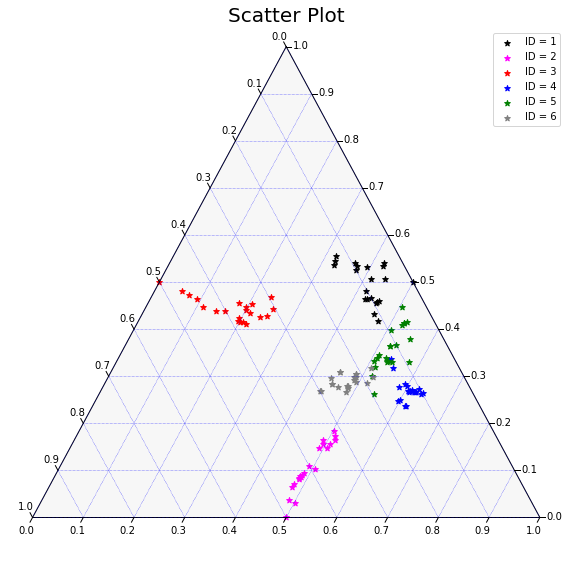

In [27]:
population.plot()

In [21]:
population.datalog.loc[np.argmin(population.datalog['Activity'])]

ID                                6
Elements               [Pt, Pd, Au]
Generation                        4
Position      [0.349, 0.354, 0.296]
Velocity      [0.009, -0.029, 0.02]
Activity                  -1.031139
Name: 29, dtype: object

In [58]:
size = 0.05
target = np.array([0.333, 0.333, 0.333])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), size, target)

In [59]:
population.datalog

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",0,"[1.0, 0.0, 0.0]","[-0.041, 0.02, 0.02]",-0.893325
1,2,"[Pt, Pd, Au]",0,"[0.0, 0.0, 1.0]","[0.02, 0.02, -0.041]",-0.242885
2,3,"[Pt, Pd, Au]",0,"[0.0, 1.0, 0.0]","[0.02, -0.041, 0.02]",-0.27646
3,4,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]","[-0.02, -0.02, 0.041]",-0.950659
4,5,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]","[-0.02, 0.041, -0.02]",-0.924154
5,6,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]","[0.041, -0.02, -0.02]",-0.279065


In [60]:
factor_1 = 0.98
factor_2 = 0.6
factor_3 = 0.7
mutation_prob = 0.7
mutation_rate = 0.3
limit_velocity = 0.1

for i in range(20):
    population.move(factor_1, factor_2, factor_3, mutation_prob, mutation_rate, limit_velocity)
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",1,"[1.016, -0.022, 0.006]","[-0.008, 0.011, -0.003]",-0.893325
1,2,"[Pt, Pd, Au]",1,"[0.083, 0.034, 0.883]","[0.083, 0.034, -0.117]",-0.639988
2,3,"[Pt, Pd, Au]",1,"[-0.214, 1.186, 0.026]","[0.107, -0.093, -0.013]",-0.27648
3,4,"[Pt, Pd, Au]",1,"[0.552, 0.414, 0.034]","[-0.026, 0.043, -0.017]",-0.952617
4,5,"[Pt, Pd, Au]",1,"[0.502, 0.106, 0.392]","[-0.001, -0.053, 0.054]",-0.948999
5,6,"[Pt, Pd, Au]",1,"[0.09, 0.51, 0.4]","[0.09, 0.01, -0.1]",-0.729077


[0.552 0.414 0.034] -0.9526170214843723
0.2662667835085706


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",2,"[1.034, -0.032, -0.002]","[-0.009, 0.005, 0.004]",-0.893325
1,2,"[Pt, Pd, Au]",2,"[0.095, 0.062, 0.844]","[0.012, 0.028, -0.039]",-0.691271
2,3,"[Pt, Pd, Au]",2,"[-0.48, 1.386, 0.094]","[0.133, -0.1, -0.034]",-0.276461
3,4,"[Pt, Pd, Au]",2,"[0.564, 0.358, 0.078]","[0.012, -0.056, 0.044]",-0.955467
4,5,"[Pt, Pd, Au]",2,"[0.517, 0.172, 0.311]","[0.015, 0.066, -0.081]",-1.006669
5,6,"[Pt, Pd, Au]",2,"[0.064, 0.487, 0.449]","[-0.026, -0.023, 0.049]",-0.309107


[0.517 0.172 0.311] -1.0066693164062492
0.14942556675482277


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",3,"[1.164, -0.078, -0.084]","[-0.065, 0.023, 0.041]",-0.893325
1,2,"[Pt, Pd, Au]",3,"[0.185, 0.013, 0.803]","[0.09, -0.049, -0.041]",-0.798648
2,3,"[Pt, Pd, Au]",3,"[-0.654, 1.74, -0.086]","[0.087, -0.177, 0.09]",-0.27646
3,4,"[Pt, Pd, Au]",3,"[0.57, 0.426, 0.004]","[0.006, 0.068, -0.074]",-0.951153
4,5,"[Pt, Pd, Au]",3,"[0.497, 0.118, 0.385]","[-0.02, -0.054, 0.074]",-0.949852
5,6,"[Pt, Pd, Au]",3,"[0.197, 0.42, 0.382]","[0.133, -0.067, -0.067]",-0.969397


[0.517 0.172 0.311] -1.0066693164062492
0.14942556675482277


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",4,"[1.126, -0.078, -0.046]","[0.019, -0.0, -0.019]",-0.893325
1,2,"[Pt, Pd, Au]",4,"[0.098, 0.104, 0.8]","[-0.087, 0.091, -0.003]",-0.713607
2,3,"[Pt, Pd, Au]",4,"[-0.76, 2.034, -0.276]","[0.053, -0.147, 0.095]",-0.27646
3,4,"[Pt, Pd, Au]",4,"[0.592, 0.343, 0.065]","[0.022, -0.083, 0.061]",-0.958748
4,5,"[Pt, Pd, Au]",4,"[0.514, 0.177, 0.31]","[0.017, 0.059, -0.075]",-1.007022
5,6,"[Pt, Pd, Au]",4,"[0.104, 0.441, 0.454]","[-0.093, 0.021, 0.072]",-0.762629


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",5,"[1.246, -0.112, -0.132]","[-0.06, 0.017, 0.043]",-0.893325
1,2,"[Pt, Pd, Au]",5,"[0.218, 0.032, 0.752]","[0.12, -0.072, -0.048]",-0.795422
2,3,"[Pt, Pd, Au]",5,"[-0.964, 2.336, -0.374]","[0.102, -0.151, 0.049]",-0.27646
3,4,"[Pt, Pd, Au]",5,"[0.557, 0.408, 0.035]","[-0.035, 0.065, -0.03]",-0.952617
4,5,"[Pt, Pd, Au]",5,"[0.515, 0.086, 0.4]","[0.001, -0.091, 0.09]",-0.930902
5,6,"[Pt, Pd, Au]",5,"[0.236, 0.377, 0.386]","[0.132, -0.064, -0.068]",-0.961562


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",6,"[1.212, -0.118, -0.09]","[0.017, 0.003, -0.021]",-0.893325
1,2,"[Pt, Pd, Au]",6,"[0.114, 0.128, 0.759]","[-0.104, 0.096, 0.007]",-0.737108
2,3,"[Pt, Pd, Au]",6,"[-1.098, 2.602, -0.508]","[0.067, -0.133, 0.067]",-0.27646
3,4,"[Pt, Pd, Au]",6,"[0.549, 0.426, 0.025]","[-0.008, 0.018, -0.01]",-0.950896
4,5,"[Pt, Pd, Au]",6,"[0.509, 0.185, 0.307]","[-0.006, 0.099, -0.093]",-1.006512
5,6,"[Pt, Pd, Au]",6,"[0.127, 0.488, 0.385]","[-0.109, 0.111, -0.001]",-0.780771


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",7,"[1.434, -0.2, -0.23]","[-0.111, 0.041, 0.07]",-0.893325
1,2,"[Pt, Pd, Au]",7,"[0.246, 0.104, 0.651]","[0.132, -0.024, -0.108]",-0.816822
2,3,"[Pt, Pd, Au]",7,"[-1.29, 2.898, -0.612]","[0.096, -0.148, 0.052]",-0.27646
3,4,"[Pt, Pd, Au]",7,"[0.537, 0.381, 0.082]","[-0.012, -0.045, 0.057]",-0.954711
4,5,"[Pt, Pd, Au]",7,"[0.559, 0.045, 0.397]","[0.05, -0.14, 0.09]",-0.925203
5,6,"[Pt, Pd, Au]",7,"[0.23, 0.391, 0.378]","[0.103, -0.097, -0.007]",-0.960543


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",8,"[1.336, -0.178, -0.154]","[0.049, -0.011, -0.038]",-0.893325
1,2,"[Pt, Pd, Au]",8,"[0.136, 0.142, 0.723]","[-0.11, 0.038, 0.072]",-0.769652
2,3,"[Pt, Pd, Au]",8,"[-1.412, 3.04, -0.632]","[0.061, -0.071, 0.01]",-0.27646
3,4,"[Pt, Pd, Au]",8,"[0.536, 0.449, 0.015]","[-0.001, 0.068, -0.067]",-0.950402
4,5,"[Pt, Pd, Au]",8,"[0.518, 0.162, 0.321]","[-0.041, 0.117, -0.076]",-1.001462
5,6,"[Pt, Pd, Au]",8,"[0.129, 0.486, 0.384]","[-0.101, 0.095, 0.006]",-0.77917


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",9,"[1.474, -0.212, -0.258]","[-0.069, 0.017, 0.052]",-0.893325
1,2,"[Pt, Pd, Au]",9,"[0.238, 0.109, 0.654]","[0.102, -0.033, -0.069]",-0.813977
2,3,"[Pt, Pd, Au]",9,"[-1.582, 3.324, -0.748]","[0.085, -0.142, 0.058]",-0.27646
3,4,"[Pt, Pd, Au]",9,"[0.561, 0.327, 0.112]","[0.025, -0.122, 0.097]",-0.962886
4,5,"[Pt, Pd, Au]",9,"[0.588, 0.0, 0.414]","[0.07, -0.162, 0.093]",-0.924154
5,6,"[Pt, Pd, Au]",9,"[0.234, 0.391, 0.374]","[0.105, -0.095, -0.01]",-0.961522


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",10,"[1.378, -0.26, -0.114]","[0.048, 0.024, -0.072]",-0.893325
1,2,"[Pt, Pd, Au]",10,"[0.168, 0.159, 0.674]","[-0.07, 0.05, 0.02]",-0.832981
2,3,"[Pt, Pd, Au]",10,"[-1.79, 3.662, -0.876]","[0.104, -0.169, 0.064]",-0.27646
3,4,"[Pt, Pd, Au]",10,"[0.607, 0.055, 0.34]","[-0.023, 0.136, -0.114]",-0.931191
4,5,"[Pt, Pd, Au]",10,"[0.523, 0.157, 0.322]","[-0.065, 0.157, -0.092]",-1.000993
5,6,"[Pt, Pd, Au]",10,"[0.114, 0.464, 0.422]","[-0.12, 0.073, 0.048]",-0.76094


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",11,"[1.602, -0.276, -0.322]","[-0.112, 0.008, 0.104]",-0.893325
1,2,"[Pt, Pd, Au]",11,"[0.213, 0.11, 0.678]","[0.045, -0.049, 0.004]",-0.814436
2,3,"[Pt, Pd, Au]",11,"[-1.916, 3.914, -1.002]","[0.063, -0.126, 0.063]",-0.27646
3,4,"[Pt, Pd, Au]",11,"[0.583, 0.267, 0.152]","[0.012, -0.106, 0.094]",-0.960634
4,5,"[Pt, Pd, Au]",11,"[0.569, 0.039, 0.394]","[0.046, -0.118, 0.072]",-0.924392
5,6,"[Pt, Pd, Au]",11,"[0.237, 0.386, 0.377]","[0.123, -0.078, -0.045]",-0.961522


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",12,"[1.494, -0.314, -0.176]","[0.054, 0.019, -0.073]",-0.893325
1,2,"[Pt, Pd, Au]",12,"[0.17, 0.183, 0.647]","[-0.043, 0.073, -0.031]",-0.848218
2,3,"[Pt, Pd, Au]",12,"[-2.03, 4.2, -1.176]","[0.057, -0.143, 0.087]",-0.27646
3,4,"[Pt, Pd, Au]",12,"[0.56, 0.356, 0.086]","[-0.023, 0.089, -0.066]",-0.963475
4,5,"[Pt, Pd, Au]",12,"[0.521, 0.131, 0.35]","[-0.048, 0.092, -0.044]",-1.006883
5,6,"[Pt, Pd, Au]",12,"[0.118, 0.471, 0.411]","[-0.119, 0.085, 0.034]",-0.759011


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",13,"[1.746, -0.402, -0.34]","[-0.126, 0.044, 0.082]",-0.893325
1,2,"[Pt, Pd, Au]",13,"[0.257, 0.082, 0.661]","[0.087, -0.101, 0.014]",-0.815204
2,3,"[Pt, Pd, Au]",13,"[-2.156, 4.454, -1.302]","[0.063, -0.127, 0.063]",-0.27646
3,4,"[Pt, Pd, Au]",13,"[0.583, 0.264, 0.155]","[0.023, -0.092, 0.069]",-0.959976
4,5,"[Pt, Pd, Au]",13,"[0.568, 0.041, 0.393]","[0.047, -0.09, 0.043]",-0.924981
5,6,"[Pt, Pd, Au]",13,"[0.239, 0.384, 0.377]","[0.121, -0.087, -0.034]",-0.961706


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",14,"[1.622, -0.38, -0.238]","[0.062, -0.011, -0.051]",-0.893325
1,2,"[Pt, Pd, Au]",14,"[0.199, 0.213, 0.588]","[-0.058, 0.131, -0.073]",-0.883677
2,3,"[Pt, Pd, Au]",14,"[-2.29, 4.72, -1.436]","[0.067, -0.133, 0.067]",-0.27646
3,4,"[Pt, Pd, Au]",14,"[0.56, 0.355, 0.087]","[-0.023, 0.091, -0.068]",-0.963475
4,5,"[Pt, Pd, Au]",14,"[0.54, 0.101, 0.361]","[-0.028, 0.06, -0.032]",-0.937771
5,6,"[Pt, Pd, Au]",14,"[0.117, 0.494, 0.389]","[-0.122, 0.11, 0.012]",-0.757811


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",15,"[1.866, -0.42, -0.442]","[-0.122, 0.02, 0.102]",-0.893325
1,2,"[Pt, Pd, Au]",15,"[0.247, 0.116, 0.637]","[0.048, -0.097, 0.049]",-0.817654
2,3,"[Pt, Pd, Au]",15,"[-2.436, 4.974, -1.544]","[0.073, -0.127, 0.054]",-0.27646
3,4,"[Pt, Pd, Au]",15,"[0.569, 0.252, 0.181]","[0.009, -0.103, 0.094]",-0.967177
4,5,"[Pt, Pd, Au]",15,"[0.552, 0.078, 0.372]","[0.012, -0.023, 0.011]",-0.929397
5,6,"[Pt, Pd, Au]",15,"[0.266, 0.395, 0.34]","[0.149, -0.099, -0.049]",-0.975504


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",16,"[1.784, -0.462, -0.32]","[0.041, 0.021, -0.061]",-0.893325
1,2,"[Pt, Pd, Au]",16,"[0.208, 0.225, 0.567]","[-0.039, 0.109, -0.07]",-0.890485
2,3,"[Pt, Pd, Au]",16,"[-2.54, 5.18, -1.648]","[0.052, -0.103, 0.052]",-0.27646
3,4,"[Pt, Pd, Au]",16,"[0.547, 0.377, 0.078]","[-0.022, 0.125, -0.103]",-0.954732
4,5,"[Pt, Pd, Au]",16,"[0.571, 0.094, 0.336]","[0.019, 0.016, -0.036]",-0.943353
5,6,"[Pt, Pd, Au]",16,"[0.151, 0.477, 0.373]","[-0.115, 0.082, 0.033]",-0.900437


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",17,"[1.838, -0.494, -0.342]","[-0.027, 0.016, 0.011]",-0.893325
1,2,"[Pt, Pd, Au]",17,"[0.23, 0.123, 0.647]","[0.022, -0.102, 0.08]",-0.846492
2,3,"[Pt, Pd, Au]",17,"[-2.674, 5.446, -1.782]","[0.067, -0.133, 0.067]",-0.27646
3,4,"[Pt, Pd, Au]",17,"[0.54, 0.248, 0.215]","[-0.007, -0.129, 0.137]",-0.997167
4,5,"[Pt, Pd, Au]",17,"[0.534, 0.113, 0.353]","[-0.037, 0.019, 0.017]",-0.94531
5,6,"[Pt, Pd, Au]",17,"[0.282, 0.42, 0.299]","[0.131, -0.057, -0.074]",-0.981387


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",18,"[1.946, -0.556, -0.39]","[-0.054, 0.031, 0.024]",-0.893325
1,2,"[Pt, Pd, Au]",18,"[0.215, 0.231, 0.555]","[-0.015, 0.108, -0.092]",-0.891262
2,3,"[Pt, Pd, Au]",18,"[-2.808, 5.712, -1.916]","[0.067, -0.133, 0.067]",-0.27646
3,4,"[Pt, Pd, Au]",18,"[0.545, 0.346, 0.113]","[0.005, 0.098, -0.102]",-0.962353
4,5,"[Pt, Pd, Au]",18,"[0.557, 0.089, 0.354]","[0.023, -0.024, 0.001]",-0.930255
5,6,"[Pt, Pd, Au]",18,"[0.196, 0.427, 0.378]","[-0.086, 0.007, 0.079]",-0.969532


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",19,"[1.968, -0.618, -0.352]","[-0.011, 0.031, -0.019]",-0.893325
1,2,"[Pt, Pd, Au]",19,"[0.229, 0.135, 0.637]","[0.014, -0.096, 0.082]",-0.848593
2,3,"[Pt, Pd, Au]",19,"[-2.954, 6.004, -2.062]","[0.073, -0.146, 0.073]",-0.27646
3,4,"[Pt, Pd, Au]",19,"[0.558, 0.213, 0.233]","[0.013, -0.133, 0.12]",-1.000993
4,5,"[Pt, Pd, Au]",19,"[0.524, 0.125, 0.351]","[-0.033, 0.036, -0.003]",-0.993219
5,6,"[Pt, Pd, Au]",19,"[0.321, 0.394, 0.286]","[0.125, -0.033, -0.092]",-0.996473


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",20,"[2.216, -0.708, -0.508]","[-0.124, 0.045, 0.078]",-0.893325
1,2,"[Pt, Pd, Au]",20,"[0.24, 0.23, 0.532]","[0.011, 0.095, -0.105]",-0.891657
2,3,"[Pt, Pd, Au]",20,"[-3.088, 6.27, -2.196]","[0.067, -0.133, 0.067]",-0.27646
3,4,"[Pt, Pd, Au]",20,"[0.55, 0.317, 0.137]","[-0.008, 0.104, -0.096]",-0.968411
4,5,"[Pt, Pd, Au]",20,"[0.556, 0.091, 0.353]","[0.032, -0.034, 0.002]",-0.9341
5,6,"[Pt, Pd, Au]",20,"[0.23, 0.386, 0.385]","[-0.091, -0.008, 0.099]",-0.960583


[0.514 0.177 0.31 ] -1.0070220898437494
0.1437045580348793


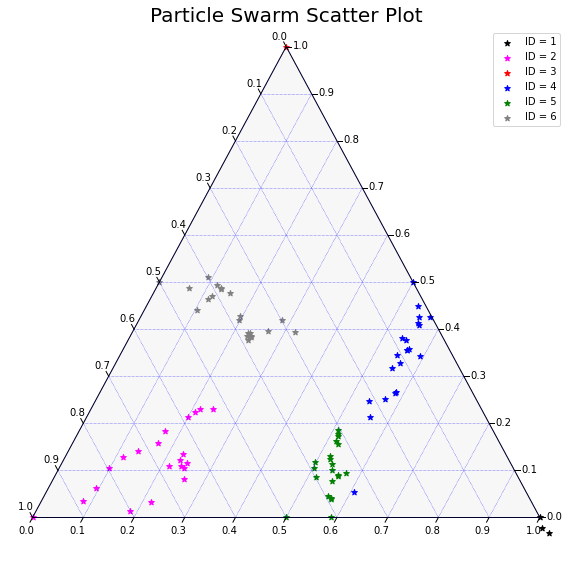

In [61]:
population.plot()

In [ ]:
#Generation colors automatically

#Generating max possible starting colors
max_color = np.array([[255, 0, 0], [204, 204, 0], [0, 204, 0], [0, 153, 204], [51, 51, 204], [204, 0, 153]])
#Generating starting colors an many of unique ID
start_color = max_color[random.sample(range(0, len(color)), len(population.working_generation))]

In [ ]:
x = grid[['Pt','Pd','Au']].to_numpy()
y = np.asarray(grid['Activity'])
y = np.reshape(y, (501501,))
fig = ff.create_ternary_contour(np.transpose(x), y,
                                pole_labels=['Pt', 'Pd', 'Au'],
                                coloring='lines',
                                showscale = True)
fig.show()